# **Stock Price Prediction Model**
COSC 325 Course Project  
Fall 2024
## Members:
  * John Paul Saia  
  * Riley Taylor  
  * Shanna Wallace  

## Objective: 
Create a machine learning model to predict the stock's closing price in 7 days

## The Data
**Data set:** Bershire Hathaway daily stock price and volume traded from 2015-01-02 to 2024-07-29  
**Format:** .csv file  

#### Target and features:

| Target | Description |
| :- | :- | 
| Close 7 Days | Closing price 7 days from the trading day |

<br>

  | Features | Description |
  | :- | :- | 
  | Date | The day the price data is from (yyyy-mm-dd) |
  | Open | Opening price | 
  | High | Highest price |
  | Low | Lowest price |
  | Close | Closing price |
  | Adj Close | Closing price after adjustments for applicable splits and dividend distributions |
  | Volume | Total number of shares traded that day |

## The Linear Regression Model
* Create a simple linear model using 3 of the features.  
* Use sequential feature selection to choose best features.  
* Create more complex linear model with polynomial expansion.  
* Compare performance of the models.  
* Optimize linear model performance. 
  * Apply techniques to reduce any underfitting or overfitting.  
  * Test different feature selections strategies  
<br>

---  


# Create Linear Regression Model:

In [91]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

## Load and Prepare Data:
* Load csv file contents to a DataFrame
* Add column for the target, Close 7 Days, by shifting Close by 7 days
* Add the additional features
* Clean the data by removing rows with missing values  

#### Additional Features:
| Features | Description |
| :- | :- | 
| High - Low | Difference between highest and lowest price |
| Open - Close | Amount price changed from open to close |
| 7 Day STD DEV | Standard deviation of closing price over previous 7 days |
| 7 Day MA | Moving averages of closing price over previous 7 days |
| 14 Day MA | Moving averages of closing price over previous 14 days |
| 21 Day MA | Moving averages of closing price over previous 21 days |  

In [92]:
RANDOM_STATE = 42
file = "./berkshire_hathaway_data.csv"
stock_data = pd.read_csv(file)



# Target is next day's closing price
# So want to target row i to correspond to row i-1 in feature columns
# Add a column called next day's close
stock_data['Close 7 Days'] = stock_data['Close'].shift(-7)


# Add columns for High Price - Low Price and 
# Closing Price - Opening Price
stock_data['High - Low'] = stock_data['High'] - stock_data['Low']
stock_data['Open - Close'] = stock_data['Open'] - stock_data['Close']

# Calculate moving average of closing price over 7 days, 14 days, and
# 21 days. 
stock_data['7 Day MA'] = stock_data['Close'].rolling(7).mean()
stock_data['14 Day MA'] = stock_data['Close'].rolling(14).mean()
stock_data['21 Day MA'] = stock_data['Close'].rolling(21).mean()

# Standard deviation of closing price over 7 days
stock_data['7 Day STD DEV'] = stock_data['Close'].rolling(7).std()

stock_data = stock_data.drop(columns=['Date'])

# Drop the rows with missing data
stock_data = stock_data.dropna().reset_index(drop=True)

stock_data.tail(10)



,Open,High,Low,Close,Adj Close,Volume,Close 7 Days,High - Low,Open - Close,7 Day MA,14 Day MA,21 Day MA,7 Day STD DEV
2371,406.239990,411.399994,405.029999,411.170013,411.170013,5149200,438.899994,6.369995,-4.930023,407.748574,408.483575,408.924764,2.229936
2372,411.269989,413.790009,408.000000,409.079987,409.079987,3559500,445.609985,5.790009,2.190002,407.580000,408.736431,408.888096,2.045406
2373,409.420013,413.709991,408.640015,410.519989,410.519989,2989700,441.820007,5.069977,-1.099976,407.947139,408.965001,408.861430,2.333281
2374,410.809998,413.959991,409.399994,413.790009,413.790009,3791800,434.470001,4.559998,-2.980011,408.945714,409.382143,408.864764,3.122721
2375,413.989990,419.200012,412.000000,418.779999,418.779999,4065200,435.980011,7.200012,-4.790009,410.887142,410.070001,409.244287,4.372873
2376,420.230011,427.450012,419.700012,424.440002,424.440002,4834600,434.010010,7.750000,-4.209991,413.364284,411.128573,410.003335,6.339244
2377,425.589996,434.709991,425.299988,434.420013,434.420013,4594900,432.799988,9.410004,-8.830017,417.457145,412.588573,411.224765,9.215259
2378,437.399994,439.049988,434.019989,438.899994,438.899994,4293700,433.290009,5.029999,-1.500000,421.418570,414.583572,412.795240,11.690049
2379,437.850006,446.149994,437.839996,445.609985,445.609985,4776600,437.660004,8.309998,-7.759979,426.637142,417.108571,414.703334,13.305970
2380,445.619995,449.250000,439.570007,441.820007,441.820007,4638300,438.309998,9.679993,3.799988,431.108573,419.527856,416.346191,12.200368


## Simple Linear Model:
### Feature Selection:
* Look at the correlation of each feature with the target and drop features with correlation value less than 0.5
* Look at the correlation of the features with the other features and drop ones that are highly correlated with each other


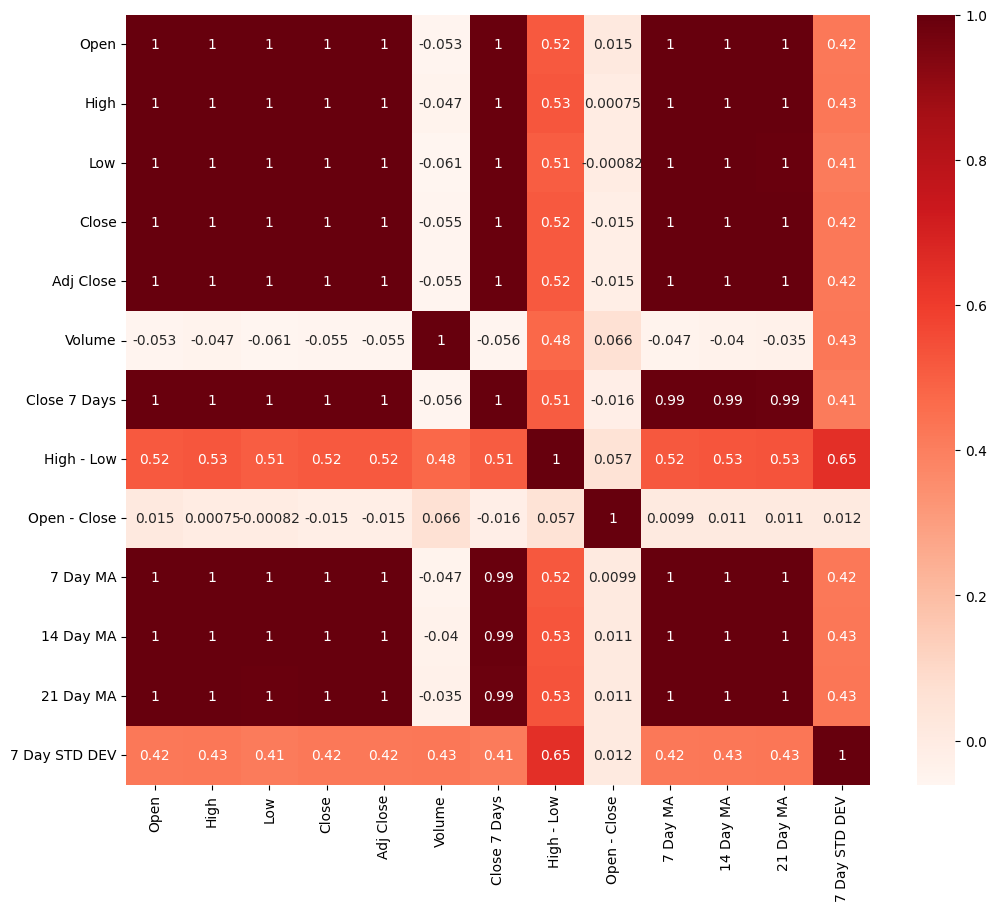

Open            0.995215
High            0.995445
Low             0.995556
Close           0.995671
Adj Close       0.995671
Close 7 Days    1.000000
High - Low      0.509619
7 Day MA        0.994454
14 Day MA       0.993033
21 Day MA       0.991635
Name: Close 7 Days, dtype: float64


In [96]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = stock_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


#Correlation with output variable
cor_target = abs(cor["Close 7 Days"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

# Drop relevant features that are highly correlated with each other
relevant_feature_list = ["Close"]

X_relevant = stock_data[relevant_feature_list]

### Create Training and Test Sets
* Extract target and selected features
* Split data in to training and testing sets
    * Training 80% / Testing 20%

In [97]:
y = stock_data['Close 7 Days']

# Separate data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_relevant, y, test_size=0.2, random_state=RANDOM_STATE)

# Print our selected features and set sizes
print(f"Training set size: {X_train.shape[0]}\nTesting set size: {X_test.shape[0]}")


Training set size: 1904
Testing set size: 477


### Create and Fit Linear Model

In [98]:
# Create the simple Model
simple_model = LinearRegression()

# Create training sets and train the model
simple_X_train = X_train
simple_X_test = X_test

simple_model.fit(simple_X_train, y_train)


LinearRegression()

### Get Predictions and Analyze Performance
* Plot the model
* Calculate performance metrics:
    * Bias
    * Variance
    * RMSE (Root Mean Squared Error)

Simple Model:
  Bias: 5,954.94
  Variance: 5,768.87
  RMSE: 8.16


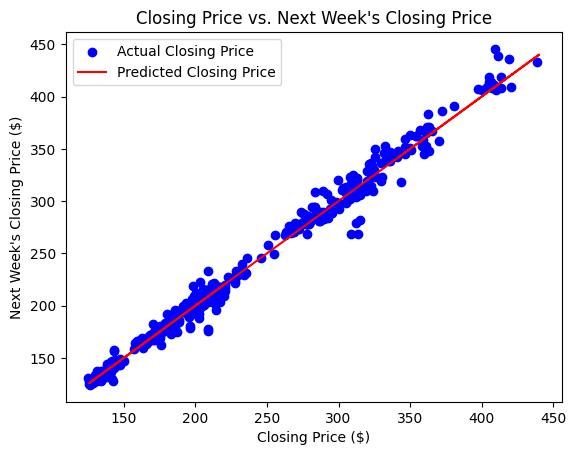

In [99]:
simple_pred = simple_model.predict(simple_X_test)

# Calculate the mean of the predictions (expected prediction)
simple_mean_pred = np.mean(simple_pred)

# Calculate bias, variance, and Root Mean Squared Error (RMSE) on the test set
simple_bias = np.mean((y_test - simple_mean_pred) ** 2)
simple_variance = np.mean((simple_pred - simple_mean_pred) ** 2)
simple_rmse = root_mean_squared_error(y_test, simple_pred)

print(f"Simple Model:\n  Bias: {simple_bias:,.2f}\n  Variance: {simple_variance:,.2f}\n  RMSE: {simple_rmse:,.2f}")


plt.scatter(simple_X_test, y_test, label='Actual Closing Price', color='blue')
plt.plot(simple_pred, simple_pred, label='Predicted Closing Price', color='red')
plt.title(f"Closing Price vs. Next Week's Closing Price")
plt.xlabel(f"Closing Price ($)")
plt.ylabel("Next Week's Closing Price ($)")
plt.legend()
plt.show()

## Linear Model with Polynomial Expansion
#### Determine optimal number of degrees to use:
* Test degree values 1 through 10 
* Compare R2 and RMSE for each
* Choose degree number that gives highest R2 and lowest RMSE


Degree with maximum R2: 6 with 0.9888337991983369
Degree with minimum RMSE: 6 with 8.154370417446305


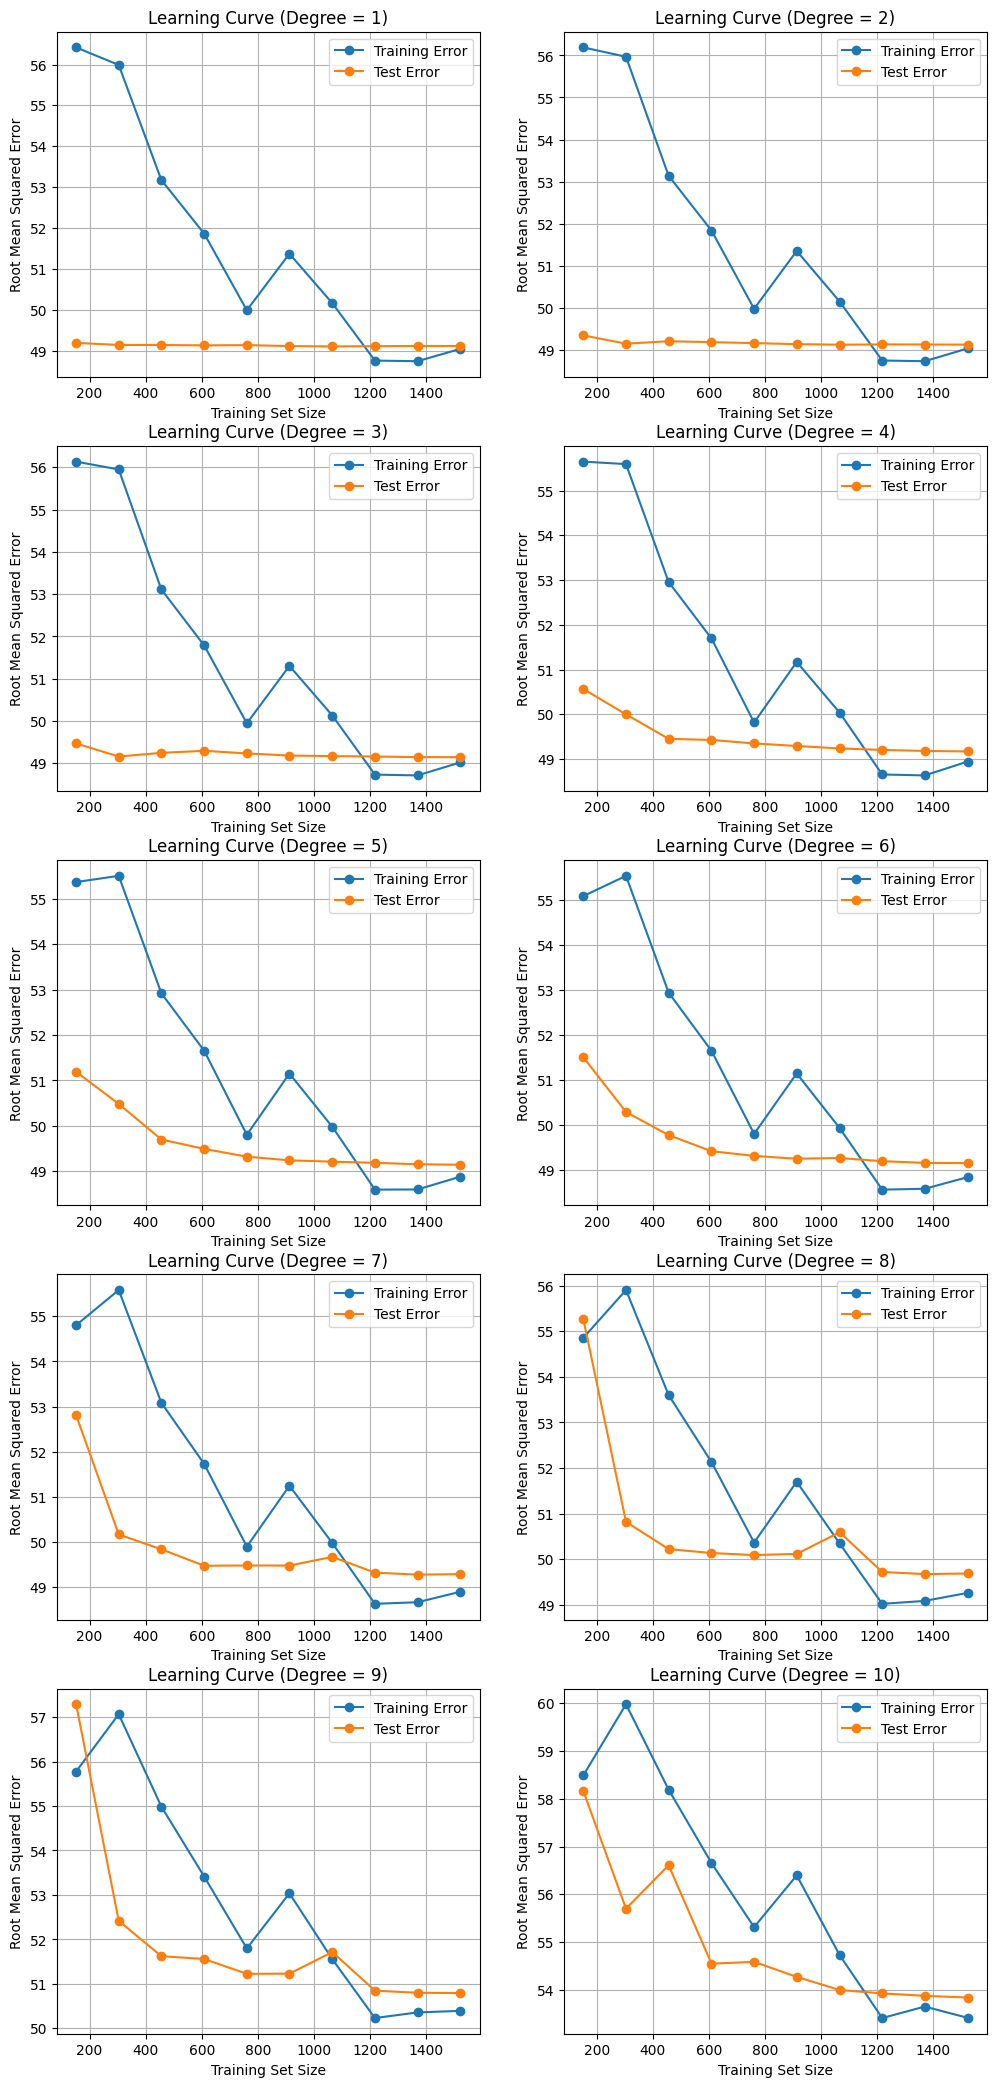

In [100]:
rmse_results = [0] * 10
r2_results = [0] * 10

fig, axes = plt.subplots(5, 2, figsize=(12, 26))
# row for the subplot
r = -1

# Define a function for plotting the learning curve
for degree in range(1, 11):
    # Complex Model: Using the features with Polynomial Expansion
    poly = PolynomialFeatures(degree=degree)

    # Transform the training and test data
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Initialize the linear regression model
    poly_model = LinearRegression()


    # Calculate learning curves for the polynomial model
    train_sizes, train_scores, test_scores = learning_curve(
        poly_model, X_train_poly, y_train, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=RANDOM_STATE
    )

    # Calculate mean error
    train_errors = -np.mean(train_scores, axis=1)
    test_errors = -np.mean(test_scores, axis=1)

    # set row and column for the subplot
    if (degree-1) % 2 == 0:
        r+=1
    c = (degree-1) % 2

    # Plot learning curves
    axes[r,c].plot(train_sizes, train_errors, label='Training Error', marker='o')
    axes[r,c].plot(train_sizes, test_errors, label='Test Error', marker='o')
    axes[r,c].set_title(f'Learning Curve (Degree = {degree})')
    axes[r,c].set_xlabel('Training Set Size')
    axes[r,c].set_ylabel('Root Mean Squared Error')
    axes[r,c].legend()
    axes[r,c].grid(True)


    # Fit the model and predict
    poly_model.fit(X_train_poly, y_train)
    poly_test_predictions = poly_model.predict(X_test_poly)

    # Calculate the mean of the predictions (expected prediction)
    poly_mean_prediction = np.mean(poly_test_predictions)

    # Calculate bias
    poly_bias = np.mean((y_test - poly_mean_prediction) ** 2)

    # Calculate variance
    poly_variance = np.mean((poly_test_predictions - poly_mean_prediction) ** 2)

    # Calculate the Root Mean Squared Error (MSE) on the Test set
    rmse_results[degree - 1] = root_mean_squared_error(y_test, poly_test_predictions)
    r2_results[degree - 1] = r2_score(y_test, poly_test_predictions)
    
# Want to minimize errors and maximize R2
max_r2 = max(r2_results)
min_rmse = min(rmse_results)
print(f"\nDegree with maximum R2: {r2_results.index(max_r2) + 1} with {max_r2}")
print(f"Degree with minimum RMSE: {rmse_results.index(min_rmse) + 1} with {min_rmse}")

### Create complex model with the best degree from testing

Complex Model:
  Bias: 5,955.01
  Variance: 5,730.00
  RMSE: 8.45
(477, 7)
(477,)


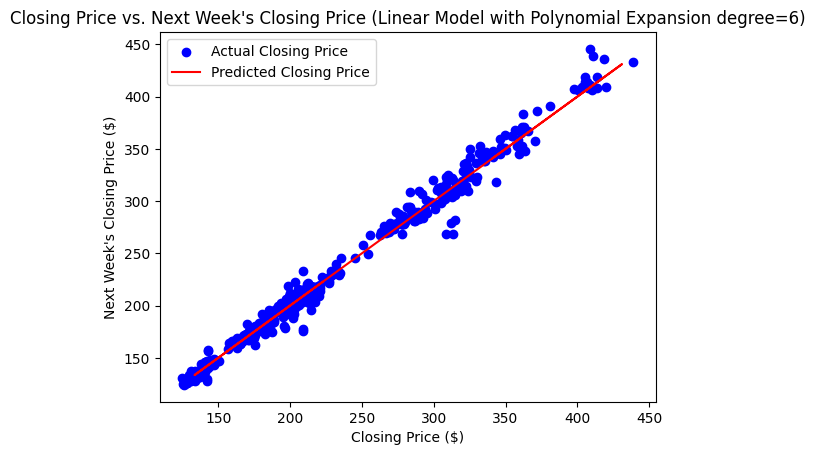

In [115]:
degree = rmse_results.index(min_rmse) + 1

# Complex Model: Using the features with Polynomial Expansion
poly = PolynomialFeatures(degree=degree)

complex_X_train = poly.fit_transform(X_train)
complex_X_test = poly.transform(X_test)

complex_model = LinearRegression()
complex_model.fit(X_train_poly, y_train)
complex_pred = complex_model.predict(X_test_poly)

# Calculate the mean of the predictions (expected prediction)
complex_mean_pred = np.mean(complex_pred)

# Calculate bias, variance, and Root Mean Squared Error (RMSE) on the test set
complex_bias = np.mean((y_test - complex_mean_pred) ** 2)
complex_variance = np.mean((complex_pred - complex_mean_pred) ** 2)
complex_rmse = root_mean_squared_error(y_test, complex_pred)

print(f"Complex Model:\n  Bias: {complex_bias:,.2f}\n  Variance: {complex_variance:,.2f}\n  RMSE: {complex_rmse:,.2f}")

print(complex_X_test.shape)
print(y_test.shape)

plt.scatter(X_test, y_test, label='Actual Closing Price', color='blue')
plt.plot(complex_pred, complex_pred, label='Predicted Closing Price', color='red')
plt.title(f"Closing Price vs. Next Week's Closing Price (Linear Model with Polynomial Expansion degree={degree})")
plt.xlabel(f"Closing Price ($)")
plt.ylabel("Next Week's Closing Price ($)")
plt.legend()
plt.show()

### Compare Simple and Complex Model

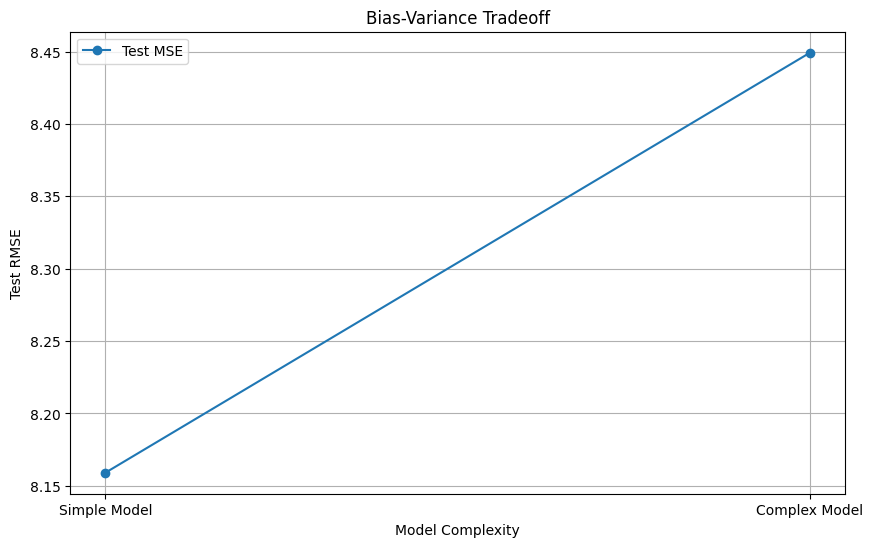

In [116]:
# Bias-Variance Tradeoff Visualization
model_complexity = ['Simple Model', 'Complex Model']
mse_scores = [simple_rmse, complex_rmse]

plt.figure(figsize=(10, 6))
plt.plot(model_complexity, mse_scores, label='Test MSE', marker='o')
plt.title('Bias-Variance Tradeoff')
plt.xlabel('Model Complexity')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid(True)
plt.show()


# Gradient Descent

Apply linear regression using gradient descent to predict the closing stock price of Berkshire Hathaway based on features like the **opening**, **high**, and **low** prices.

 Use different **learning rates** to understand how they affect the convergence of the cost function during gradient descent.

The goal is to find the **optimal learning rate** that minimizes the cost function efficiently, resulting in the best model for predicting the stock's closing price.


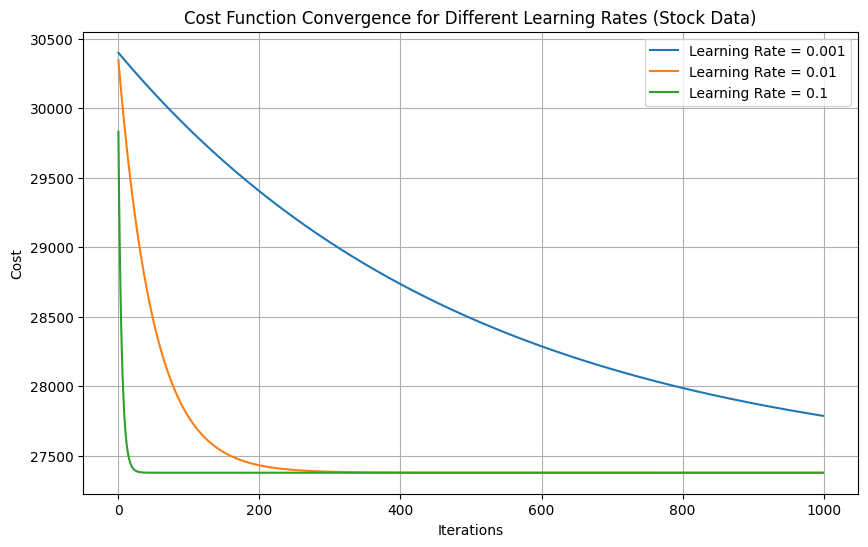

In [103]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the cost function
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1/(2*m)) * np.sum(np.square(predictions - y))
    return cost

# Define the gradient descent function (with cost history tracking)
def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)  # number of samples
    cost_history = np.zeros(iterations)  # To store the cost at each iteration
    
    for i in range(iterations):
        predictions = X.dot(theta)
        errors = predictions - y
        gradient = (1/m) * X.T.dot(errors)
        theta = theta - alpha * gradient
        cost_history[i] = compute_cost(X, y, theta)  # Save the cost at each iteration
    
    return theta, cost_history

# Initialize parameters for gradient descent
iterations = 1000
theta = np.zeros(X_train_scaled.shape[1])  # Initialize theta with zeros

# Test with different learning rates
learning_rates = [0.001, 0.01, 0.1]
plt.figure(figsize=(10, 6))

for alpha in learning_rates:
    theta = np.zeros(X_train_scaled.shape[1])  # Reset theta for each learning rate
    theta, cost_history = gradient_descent(X_train_scaled, y_train, theta, alpha, iterations)
    plt.plot(range(iterations), cost_history, label=f'Learning Rate = {alpha}')

# Plot the cost function convergence
plt.title('Cost Function Convergence for Different Learning Rates (Stock Data)')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()